# Maestría en Inteligencia Artificial Aplicada 

## Curso: Proyecto Integrador (Grupo 10) 

## Avance 5. Modelo Final.
<br />

### Profesor titular  
#### Dra. Grettel Barceló Alonso 
#### Dr. Luis Eduardo Falcón Morales  
<br />

<table>
<tr>
    <th colspan="2">Equipo 19: Los Californios I</th>
</tr>
<tr>
    <td>Ernesto Zapata Garza</td><td>A00915255</td>
</tr>
<tr>
    <td>Rafael García Domínguez</td><td>A01328974</td>
</tr>
<tr>
    <td>Erik López Hernández</td><td>A00458875</td>
</tr>
</table>
<br />

##### 1 de junio de 2025

Este notebook construye, evalúa y compara todos los modelos alternativos para predecir emociones narrativas en escenas del guion *Los Californios*, con la intención de seleccionar el modelo final para la generación de *prompts* para las herramientas de Inteligencia Artificial Generativa.

In [1]:
import warnings
warnings.filterwarnings('ignore')

## Instalaciones necesarias

In [2]:
!pip install spacy


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
!python -m spacy download es_core_news_md

     ---------------------------------------- 0.0/42.3 MB ? eta -:--:--
     -- ------------------------------------- 2.4/42.3 MB 16.8 MB/s eta 0:00:03
     ----------- --------------------------- 12.8/42.3 MB 38.4 MB/s eta 0:00:01
     ----------------- --------------------- 18.6/42.3 MB 33.5 MB/s eta 0:00:01
     -------------------------- ------------ 28.6/42.3 MB 37.7 MB/s eta 0:00:01
     ----------------------------- --------- 31.7/42.3 MB 33.5 MB/s eta 0:00:01
     --------------------------------------  42.2/42.3 MB 36.3 MB/s eta 0:00:01
     --------------------------------------- 42.3/42.3 MB 34.5 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_md')



[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
!pip install transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
!pip install torch


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [6]:
!pip install huggingface_hub[hf_xet]


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [7]:
!pip3 install emoji==0.6.0


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [8]:
!pip install deep-translator


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [9]:
!pip install sentence_transformers


[notice] A new release of pip is available: 24.3.1 -> 25.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


## Construcción inicial del dataframe

In [10]:
# Importación de librerías
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pathlib import Path
import spacy

# Cargar modelo de NLP
nlp = spacy.load('es_core_news_md')

In [11]:
# Carga y limpieza del guion
ruta_guion = Path('../data/LosCaliforniosScript.txt')
with open(ruta_guion, encoding='utf-8') as f:
    guion_crudo = f.read()

# Separación preliminar por escenas
escenas = re.split(r'\n\(\d+\)\s+(EXT\.|INT\.)', guion_crudo)
escenas = [e.strip() for e in escenas if len(e.strip()) > 100]

df = pd.DataFrame({'escena_texto': escenas})
df['num_palabras'] = df['escena_texto'].apply(lambda x: len(x.split()))
df.head()

,escena_texto,num_palabras
0,Los Californios\n1\nAutor. Carlos Peralta Dávi...,5665
1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,594
2,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",1069
3,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",187
4,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,97


In [12]:
# Extracción de personajes con NLP
df['doc'] = df['escena_texto'].apply(nlp)
df['personajes'] = df['doc'].apply(lambda d: list(set([ent.text for ent in d.ents if ent.label_ == 'PER'])))

from collections import Counter

personajes_todos = df['personajes'].explode()
conteo_personajes = Counter(personajes_todos)

personajes_filtrados = [p for p, c in conteo_personajes.items() if c >= 5 and len (p.split()) <= 3]
df['personajes_filtrados'] = df['personajes'].apply(lambda lista: [p for p in lista if p in personajes_filtrados])

df[['escena_texto', 'personajes_filtrados']].head()

,escena_texto,personajes_filtrados
0,Los Californios\n1\nAutor. Carlos Peralta Dávi...,"[Mariana, Mariana Austri, Nakai, Aldara, Josef..."
1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,[]
2,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...","[Luis María, Pablo, San Antonio, Zoey, Peralta]"
3,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",[Luis María]
4,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,[]


## Clasificación automática de emociones por escena

In [ ]:
from huggingface_hub import login
login('TOKEN')

In [14]:
from transformers import pipeline
from deep_translator import GoogleTranslator

emotion_classifier = pipeline('text-classification', model='j-hartmann/emotion-english-distilroberta-base', top_k=1, device=-1)
translator = GoogleTranslator(source='es', target='en')

def detectar_emocion(texto):
    try:
        oraciones = re.split(r'[.!?]', texto)
        entrada = ' '.join(oraciones[:5]).strip()[:300]
        entrada_en = translator.translate(entrada)
        result = emotion_classifier(entrada_en)
        return result[0][0].get('label', 'desconocido')
    except Exception as e:
        print(f'Error:', e)
        return 'desconocido'
    
df['emocion'] = df['escena_texto'].apply(detectar_emocion)
df[['escena_texto', 'emocion']].head()

Device set to use cpu


,escena_texto,emocion
0,Los Californios\n1\nAutor. Carlos Peralta Dávi...,neutral
1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,anger
2,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",joy
3,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",joy
4,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,fear


## Clustering temático con Sentence Transformers

In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans

model = SentenceTransformer('distiluse-base-multilingual-cased-v1', device='cpu')
embeddings = model.encode(df['escena_texto'].tolist())
kmeans = KMeans(n_clusters=5, random_state=42)
df['tema_cluster'] = kmeans.fit_predict(embeddings)
df[['tema_cluster', 'escena_texto']].groupby('tema_cluster').head(1)

,tema_cluster,escena_texto
0,3,Los Californios\n1\nAutor. Carlos Peralta Dávi...
1,1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...
3,2,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta..."
14,4,FRENTE IGLESIA – TUBAC SONORA – DÍA\n\nSOBREPU...
18,0,"CASA DE LA FAMILIA – CONTINUA\n\n\nLa HIJA, es..."


## Limpieza y tratamiento de valores nulos o atípicos

In [16]:
df['escena_text'] = df['escena_texto'].str.strip()
print('Valores nulos por columna: ')
print(df.isnull().sum())
df.fillna("desconocido", inplace=True)

Valores nulos por columna: 
escena_texto            0
num_palabras            0
doc                     0
personajes              0
personajes_filtrados    0
emocion                 0
tema_cluster            0
escena_text             0
dtype: int64


In [17]:
# Calcular datos necesarios para el dashboard

# Escenas por personaje (Top 10)
personajes_escenas = df['personajes_filtrados'].explode().value_counts().head(10)

# Emociones detectadas
emociones = df['emocion'].value_counts()

# Clusters temáticos (si existe esa columna)
if 'tema_cluster' in df.columns:
    temas = df['tema_cluster'].value_counts().sort_index()
else:
    temas = pd.Series()


## Importación de paquetes necesarios

In [18]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold

## Generación y codificación de nuevas características

In [19]:
df = pd.concat([df, pd.get_dummies(df['emocion'], prefix='em')], axis=1)
df['num_personajes'] = df['personajes_filtrados'].apply(len)
df['escena_coral'] = (df['num_personajes'] > 1).astype(int)
df.head()

,escena_texto,num_palabras,doc,personajes,personajes_filtrados,emocion,tema_cluster,escena_text,em_anger,em_disgust,em_fear,em_joy,em_neutral,em_sadness,num_personajes,escena_coral
0,Los Californios\n1\nAutor. Carlos Peralta Dávi...,5665,"(Los, Californios, \n, 1, \n, Autor, ., Carlos...","[Mariana, Juan Bautista de Anza Bezerra Nieto,...","[Mariana, Mariana Austri, Nakai, Aldara, Josef...",neutral,3,Los Californios\n1\nAutor. Carlos Peralta Dávi...,False,False,False,False,True,False,15,1
1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,594,"(DESIERTO, DE, SONORA, Y, ARIZONA, –, AMANECER...",[Californios],[],anger,1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,True,False,False,False,False,False,0,0
2,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",1069,"(2465, 34TH, AVE, ,, OAKLAND, –, DÍA, \n\n\n, ...","[Luis María, Sophie, Vestida, Pablo, Tiburcio ...","[Luis María, Pablo, San Antonio, Zoey, Peralta]",joy,3,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",False,False,False,True,False,False,5,1
3,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",187,"(MARKET, STREET, ,, SAN, FRANCISCO, -, DÍA, \n...","[Luis María, Luis María Peralta Valenzuela, Di...",[Luis María],joy,2,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",False,False,False,True,False,False,1,0
4,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,97,"(CALIFORNIA, STREET, SAN, FRANCISCO-, DÍA, \n\...",[],[],fear,2,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,False,False,True,False,False,False,0,0


## Normalización de variables numéricas

In [20]:
scaler = MinMaxScaler()
df[['norm_longitud', 'norm_personajes']] = scaler.fit_transform(df[['num_palabras', 'num_personajes']])
df.head()

,escena_texto,num_palabras,doc,personajes,personajes_filtrados,emocion,tema_cluster,escena_text,em_anger,em_disgust,em_fear,em_joy,em_neutral,em_sadness,num_personajes,escena_coral,norm_longitud,norm_personajes
0,Los Californios\n1\nAutor. Carlos Peralta Dávi...,5665,"(Los, Californios, \n, 1, \n, Autor, ., Carlos...","[Mariana, Juan Bautista de Anza Bezerra Nieto,...","[Mariana, Mariana Austri, Nakai, Aldara, Josef...",neutral,3,Los Californios\n1\nAutor. Carlos Peralta Dávi...,False,False,False,False,True,False,15,1,0.838135,0.535714
1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,594,"(DESIERTO, DE, SONORA, Y, ARIZONA, –, AMANECER...",[Californios],[],anger,1,DESIERTO DE SONORA Y ARIZONA – AMANECER\n\nImá...,True,False,False,False,False,False,0,0,0.085091,0.000000
2,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",1069,"(2465, 34TH, AVE, ,, OAKLAND, –, DÍA, \n\n\n, ...","[Luis María, Sophie, Vestida, Pablo, Tiburcio ...","[Luis María, Pablo, San Antonio, Zoey, Peralta]",joy,3,"2465 34TH AVE, OAKLAND – DÍA\n\n\nSOBREPUESTO\...",False,False,False,True,False,False,5,1,0.155628,0.178571
3,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",187,"(MARKET, STREET, ,, SAN, FRANCISCO, -, DÍA, \n...","[Luis María, Luis María Peralta Valenzuela, Di...",[Luis María],joy,2,"MARKET STREET, SAN FRANCISCO - DÍA\nLa carreta...",False,False,False,True,False,False,1,0,0.024651,0.035714
4,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,97,"(CALIFORNIA, STREET, SAN, FRANCISCO-, DÍA, \n\...",[],[],fear,2,CALIFORNIA STREET SAN FRANCISCO- DÍA\n\n\nLa c...,False,False,True,False,False,False,0,0,0.011286,0.000000


## Selección y reducción de características

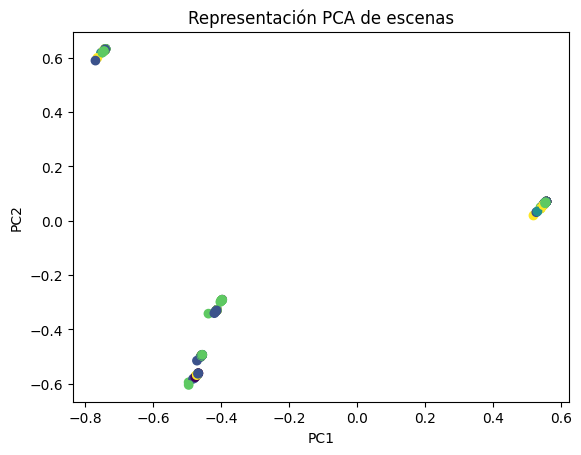

In [21]:
columnas_emocion = list(df.columns[df.columns.str.startswith('em_')])
X = df[['norm_longitud', 'norm_personajes'] + columnas_emocion]

selector = VarianceThreshold(threshold=0.01)
X_reduced = selector.fit_transform(X)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df['tema_cluster'], cmap='viridis')
plt.title('Representación PCA de escenas')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.show()

## Similitud entre escenas y personajes con embeddings

In [22]:
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer

# Se extraen las escenas y se generan nombres de escenas
escenas = df['escena_texto'].tolist()
nombres_escenas = [f'Escena {i+1}' for i in range(len(escenas))]

# Se carga el modelo y se generan los embeddings
model = SentenceTransformer('distiluse-base-multilingual-cased-v1')
embeddings = model.encode(escenas)

# Se calcula matriz de similitud
sim_matrix = cosine_similarity(embeddings)

# Se genera un dataframe temporal para desplegar los resultados de forma legible.
df_sim = pd.DataFrame(sim_matrix, index=nombres_escenas, columns=nombres_escenas)

In [23]:
import numpy as np
# Convertir la matriz en formato largo (pares de escena)
sim_pairs = df_sim.where(~np.eye(df_sim.shape[0], dtype=bool))  # Elimina la diagonal (1.0 de autocomparación)
sim_pairs = sim_pairs.stack().reset_index()
sim_pairs.columns = ['Escena A', 'Escena B', 'Similaridad']

# Ordenar de mayor a menor
sim_pairs = sim_pairs.sort_values(by='Similaridad', ascending=False)

# Opcional: eliminar duplicados (Ej: A-B y B-A)
sim_pairs['Escenas'] = sim_pairs[['Escena A', 'Escena B']].apply(lambda x: tuple(sorted(x)), axis=1)
sim_pairs = sim_pairs.drop_duplicates(subset='Escenas').drop(columns='Escenas')

# Mostrar top 10 pares más similares
print('10 escenas con mayor similitud:')
sim_pairs.head(10)

10 escenas con mayor similitud:


,Escena A,Escena B,Similaridad
12986,Escena 62,Escena 55,1.000000
11082,Escena 53,Escena 60,1.000000
5317,Escena 26,Escena 18,0.979297
11721,Escena 56,Escena 63,0.977420
11295,Escena 54,Escena 61,0.963691
4055,Escena 20,Escena 29,0.960901
5742,Escena 28,Escena 19,0.879462
15976,Escena 76,Escena 78,0.827906
10868,Escena 52,Escena 58,0.817077
13412,Escena 64,Escena 57,0.798230


## Baseline usando el dataframe

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, f1_score
from sklearn.feature_selection import SelectKBest, chi2

In [25]:
X_texto = df['escena_texto']
y = df['emocion']

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_texto)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

## Entrenamiento del modelo baseline y evaluación

In [26]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))
print("\nReporte de clasificación:\n")
print(classification_report(y_test, y_pred))

Accuracy: 0.609375
F1 Score: 0.46146844660194175

Reporte de clasificación:

              precision    recall  f1-score   support

       anger       0.00      0.00      0.00         4
     disgust       0.00      0.00      0.00         1
        fear       0.61      1.00      0.76        39
         joy       0.00      0.00      0.00         8
     neutral       0.00      0.00      0.00         7
     sadness       0.00      0.00      0.00         5

    accuracy                           0.61        64
   macro avg       0.10      0.17      0.13        64
weighted avg       0.37      0.61      0.46        64



## Palabras más relevantes según chi-cuadrado

In [27]:
selector = SelectKBest(score_func=chi2, k=10)
selector.fit(X, y)
selected_words = np.array(vectorizer.get_feature_names_out())[selector.get_support()]
print("Palabras más importantes según chi2:", selected_words)

Palabras más importantes según chi2: ['carpentier' 'hereje' 'impuesto' 'inquisición' 'insulta' 'inuk' 'josefa'
 'pedro' 'pregonero' 'virrey']


## Visualización PCA de escenas por emoción

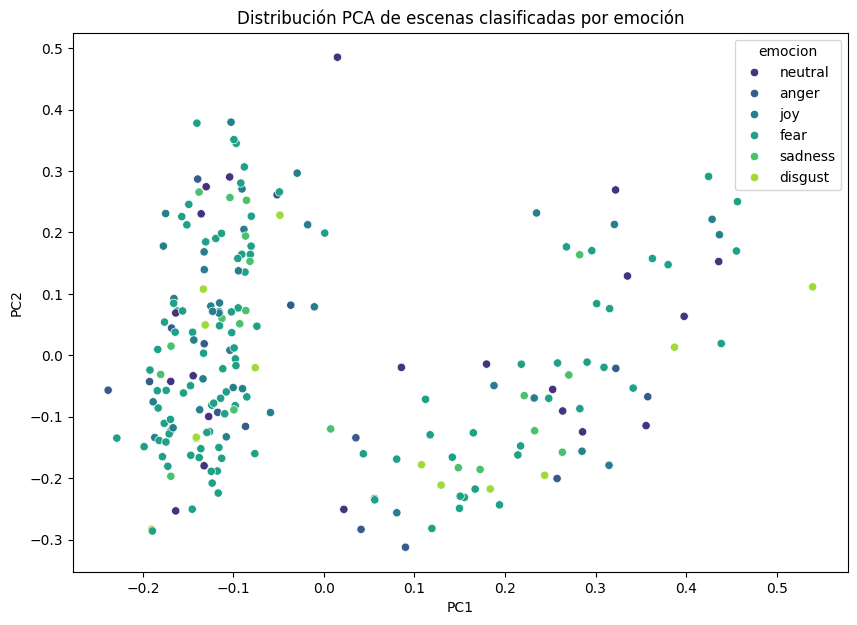

In [28]:
X_dense = X.toarray()
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_dense)

df_pca = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
df_pca['emocion'] = y.values

plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='emocion', palette='viridis')
plt.title("Distribución PCA de escenas clasificadas por emoción")
plt.show()

## Validación cruzada del modelo baseline

In [29]:
scores = cross_val_score(model, X, y, cv=5, scoring='f1_weighted')
print("F1 ponderado promedio (CV 5-fold):", np.mean(scores))

F1 ponderado promedio (CV 5-fold): 0.3309869878183832


## Preparación de datos

In [30]:
import time
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

In [31]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(df['escena_texto'])
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(df['emocion'])

X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.3, random_state=42)

## Entrenamiento de modelos individuales

In [32]:
modelos = {
    'LogisticRegression': LogisticRegression(max_iter=1000),
    'MultinomialNB': MultinomialNB(),
    'RandomForest': RandomForestClassifier(),
    'KNeighbors': KNeighborsClassifier(),
    'SVC': SVC(),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='mlogloss')
}

resultados = []
for nombre, modelo in modelos.items():
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.time() - start
    resultados.append({
        'modelo': nombre,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'tiempo_seg': duracion
    })

## Comparativa de resultados

,modelo,accuracy,f1_macro,f1_weighted,tiempo_seg
5,XGBoost,0.546875,0.238017,0.510008,3.497925
3,KNeighbors,0.421875,0.163889,0.401302,0.004999
4,SVC,0.609375,0.162450,0.486317,0.102002
2,RandomForest,0.609375,0.160000,0.488125,0.443767
1,MultinomialNB,0.609375,0.126214,0.461468,0.001999
0,LogisticRegression,0.609375,0.126214,0.461468,0.428475


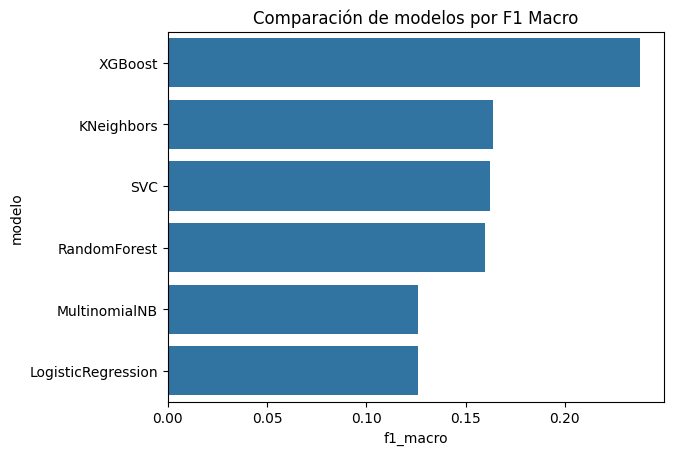

In [33]:
df_resultados = pd.DataFrame(resultados)
df_resultados = df_resultados.sort_values(by='f1_macro', ascending=False)
display(df_resultados)

sns.barplot(x='f1_macro', y='modelo', data=df_resultados)
plt.title('Comparación de modelos por F1 Macro')
plt.show()

## Ajuste fino de los dos mejores modelos

In [34]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

param_xgb = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.3],
    'subsample': [0.8, 1]
}

grid_xgb = GridSearchCV(
    estimator=XGBClassifier(use_label_encoder=False, eval_metric='mlogloss'),
    param_grid=param_xgb,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_xgb.fit(X_train, y_train)
print("Mejor score (XGBoost):", grid_xgb.best_score_)
print("Mejores parámetros:", grid_xgb.best_params_)

Fitting 3 folds for each of 54 candidates, totalling 162 fits
Mejor score (XGBoost): 0.2082323621797306
Mejores parámetros: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 200, 'subsample': 1}


In [35]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

param_knn = {
    'n_neighbors': [3, 5, 7, 9],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid_knn = GridSearchCV(
    estimator=KNeighborsClassifier(),
    param_grid=param_knn,
    scoring='f1_macro',
    cv=3,
    verbose=1,
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)
print("Mejor score (KNN):", grid_knn.best_score_)
print("Mejores parámetros:", grid_knn.best_params_)

Fitting 3 folds for each of 16 candidates, totalling 48 fits
Mejor score (KNN): 0.25518837803320565
Mejores parámetros: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}


## Ensambles

### Entrenar al menos 4 modelos de ensamble:

#### 2 homogéneos:
- Random Forest
- XGBoost

#### 2 heterogéneos:
- VotingClassifier
- StackingClassifier


In [36]:
from sklearn.ensemble import VotingClassifier, StackingClassifier

# Modelos base ya ajustados previamente
estimadores_stack = [
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance', metric='euclidean')),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=10, learning_rate=0.01, subsample=1, use_label_encoder=False, eval_metric='mlogloss')),
    ('svc', SVC(probability=True))
]

# Modelos de ensamble
modelos_ensamble = {
    'RandomForest': RandomForestClassifier(n_estimators=200),
    'XGBoost': XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric='mlogloss'),
    'Voting': VotingClassifier(estimators=estimadores_stack, voting='soft'),
    'Stacking': StackingClassifier(estimators=estimadores_stack, final_estimator=LogisticRegression())
}

# Evaluación de modelos
resultados_ensamble = []
for nombre, modelo in modelos_ensamble.items():
    start = time.time()
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    duracion = time.time() - start
    resultados_ensamble.append({
        'modelo': nombre,
        'accuracy': accuracy_score(y_test, y_pred),
        'f1_macro': f1_score(y_test, y_pred, average='macro'),
        'f1_weighted': f1_score(y_test, y_pred, average='weighted'),
        'tiempo_seg': duracion
    })

# Resultados ordenados por F1 macro
df_ensamble = pd.DataFrame(resultados_ensamble).sort_values(by='f1_macro', ascending=False)
display(df_ensamble)


,modelo,accuracy,f1_macro,f1_weighted,tiempo_seg
1,XGBoost,0.562500,0.255282,0.523255,7.703187
0,RandomForest,0.609375,0.162450,0.486317,2.123966
2,Voting,0.593750,0.153628,0.480974,7.290654
3,Stacking,0.609375,0.126214,0.461468,29.708154


### Modelo Final Seleccionado

In [37]:
modelo_final = modelos_ensamble['XGBoost']
y_pred_final = modelo_final.predict(X_test)

### Matriz de Confusión

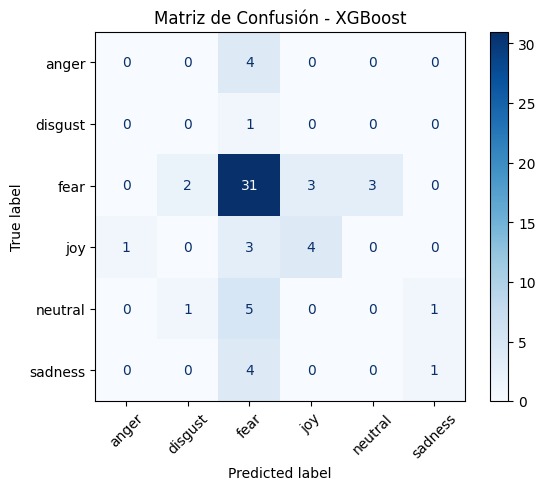

In [38]:
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

cm = confusion_matrix(y_test, y_pred_final)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Matriz de Confusión - XGBoost")
plt.show()

### Curvas ROC multiclase

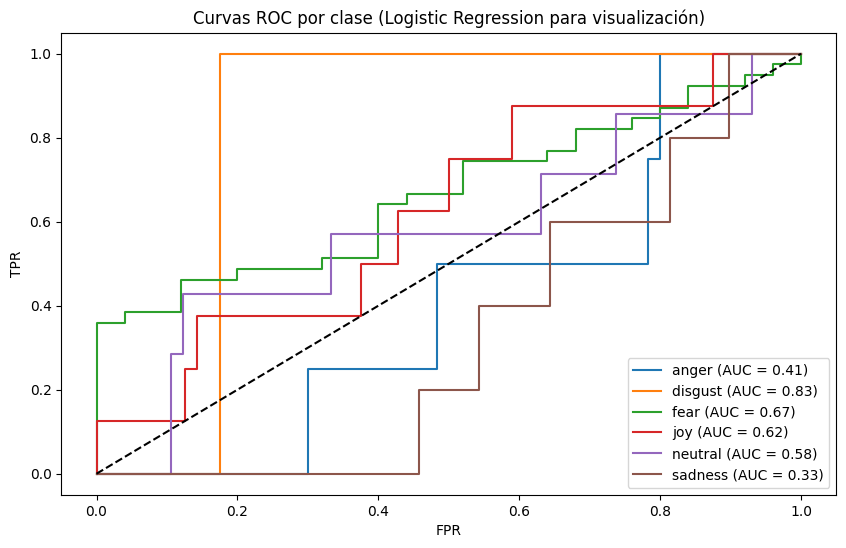

In [47]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

# Reentrenamos para fines visuales solamente
logreg_ovr = OneVsRestClassifier(LogisticRegression(max_iter=1000))
logreg_ovr.fit(X_train, y_train)

y_score = logreg_ovr.predict_proba(X_test)
y_test_bin = label_binarize(y_test, classes=label_encoder.transform(label_encoder.classes_))

fpr = dict()
tpr = dict()
roc_auc = dict()

for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(10, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC = {roc_auc[i]:.2f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.title("Curvas ROC por clase (Logistic Regression para visualización)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()

### Importancia de Características

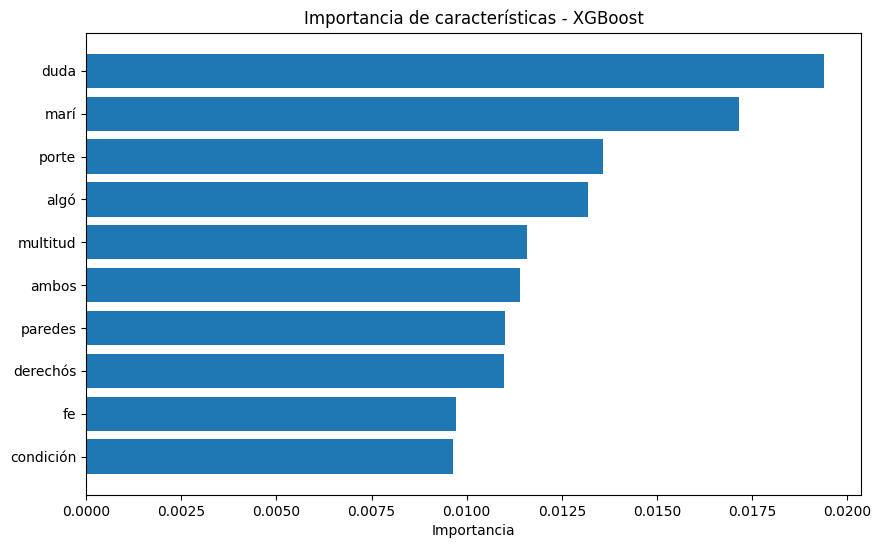

In [48]:
importances = modelo_final.feature_importances_
feature_names = vectorizer.get_feature_names_out()
indices = np.argsort(importances)[-10:]

plt.figure(figsize=(10, 6))
plt.barh(range(len(indices)), importances[indices], align="center")
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("Importancia de características - XGBoost")
plt.xlabel("Importancia")
plt.show()